# Data Preparation

In [1]:
from pandas import DataFrame
from datetime import datetime

In [2]:
class MVTSSample:
    
    def __init__(self, active_region:str, flare_class:str, flare_type:str, \
                 verification:str, start_time:datetime, end_time:datetime, data:DataFrame):
        self.flare_type = flare_type
        self.active_region = active_region
        self.flare_class = flare_class
        self.verification = verification
        self.start_time = start_time
        self.end_time = end_time
        self.data = data
    
    def get_flare_type(self):
        return self.flare_type
    
    def get_flare_class(self):
        return self.flare_class
    
    def get_active_region(self):
        return self.active_region
    
    def get_verification(self):
        return self.verification
    
    def get_start_time(self):
        return self.start_time
    
    def get_end_time(self):
        return self.end_time
    
    def get_data(self):
        return self.data

In [3]:
import os
import pandas as pd

In [4]:
def read_mvts_instance(data_dir:str, file_name:str) -> MVTSSample: #Finished!
    # Get flare type from file name
    if file_name[0:1] == 'F' :
        flare_type = file_name[0:2]
    else:
        flare_type = file_name[0:4]
    active_region = file_name[file_name.find('_ar')+3: file_name.find('_s2')]
    
    verification = 'FQ'
    flare_class = 'FQ'
    if file_name[0:1] != 'F' :
        verification = file_name.split(':')[1].split('_')[0]
        flare_class = file_name[0:1]
    

    try:
        # Get start time from file name
        start = file_name.find('s2')
        start_time = file_name[start+1: start+20]
        start_time = start_time.replace("T", " ")
        start_time = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")

        # Get end time from file name
        end = file_name.find('e2')
        end_time = file_name[end+1: end+20]
        end_time = end_time.replace("T", " ")
        end_time = datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        print(ValueError)
        pass

    # Get data from csv file
    try:
        data = pd.read_csv(data_dir + "/" + file_name, sep="\t")
        data['Timestamp'] = data['Timestamp'].str.replace('-', '')
        data['Timestamp'] = data['Timestamp'].str.replace(' ', '')
        data['Timestamp'] = data['Timestamp'].str.replace(':', '')
    except ValueError:
        print(ValueError)
        pass
    
    # Make mvts object 
    mvts = MVTSSample(active_region, flare_class, flare_type, verification, start_time, end_time, data)
    return mvts

In [5]:
import numpy as np

In [6]:
from os import listdir

In [43]:
import csv
import numpy as np
import pickle
from tqdm import tqdm


def process_partition(partition_location:str, data_dir_save:str, abt_name:str):
    abt_header = ['Timestamp', 'R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                           'USFLUX','TOTFZ','MEANPOT', 'EPSX', 'EPSY','EPSZ','MEANSHR','SHRGT45','MEANGAM',
                              'MEANGBT','MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']
    
    abt_header_label = ['FLARE_CLASS', 'FLARE_TYPE', 'ACTIVE_REGION', 'VERIFICATION']
    
    abt_label = pd.DataFrame(columns=abt_header_label)
    

    # Get lists of data from partition
    FL = os.listdir(partition_location + "/FL")
    NF = os.listdir(partition_location + "/NF")
    FN_NO_FQ = [i for i in NF if i[0:2]!='FQ']
    FN_FQ = [i for i in NF if i[0:2]=='FQ']
    
    Files = sorted(FL, reverse=True) + sorted(FN_NO_FQ, reverse=True) + FN_FQ
    
    number_of_features=25
    number_of_timestamps=60
    abt = np.zeros((number_of_timestamps,number_of_features,len(Files)))
    
    count = 0
    # Add row to abt from mvssample object and its median and std data
    with tqdm(len(Files)) as pbar:

        for d in Files:

            # Use temp list for each row and temp df
            list2add_label = []
            tempdf = pd.DataFrame(columns=abt_header)
            tempdf_label = pd.DataFrame(columns=abt_header_label)

            # Get mvs object and add flare type 
            if d in FL:
                mvs = read_mvts_instance(partition_location + '/FL', d)
            else:
                mvs = read_mvts_instance(partition_location + '/NF', d)
            list2add_label.append(mvs.get_flare_class())
            list2add_label.append(mvs.get_flare_type())
            list2add_label.append(mvs.get_active_region())
            list2add_label.append(mvs.get_verification())


            # Set up temp df for future concat with master data frame object
            templist = mvs.get_data()[abt_header]
            templist = templist.to_numpy()

            # From data frame concat current with temp for each feature 
            abt[:,:,count] = templist

            tempdf_label.loc[len(abt_header_label)] = list2add_label
            abt_label = pd.concat([abt_label, tempdf_label], ignore_index= True, axis = 0)


            count +=1
            pbar.update(1)
            #if count >= 1000:
                #break
            #continue
            

    print(abt_name)        
    print("shape: " + str(abt.shape))
    with open(data_dir_save + "raw/" + abt_name + ".pkl", 'wb') as f:
        pickle.dump(abt, f)
        
    abt_label.to_csv(data_dir_save + "labels/" + abt_name + "_labels.csv", index=False, header=True)
    # return the completed analitics base table
    return abt_label

# Data Exploration

In [44]:

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/Data"  
data_dir_save = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/"  

# change the path to where your data is stored.


for i in range(1,6):
    abt_name = "partition" + str(i) # Corrected to partition 1
    abt = process_partition(data_dir + "/" + "partition" + str(i), data_dir_save, abt_name)
    print("number of instances: " + str(abt.shape[0]))
    print(abt.head(5))
    print('\n')

73492it [03:39, 334.46it/s]


partition1
shape: (60, 25, 73492)
number of instances: 73492
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           X       X6.9           753      Primary
1           X       X6.9           753      Primary
2           X       X6.9           753      Primary
3           X       X6.9           753      Primary
4           X       X6.9           753      Primary




88557it [04:44, 311.15it/s]


partition2
shape: (60, 25, 88557)
number of instances: 88557
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           X       X1.4          1834      Primary
1           X       X1.4          1834      Primary
2           X       X1.4          1834      Primary
3           X       X1.4          1834      Primary
4           X       X1.4          1834      Primary




42510it [01:56, 364.95it/s]


partition3
shape: (60, 25, 42510)
number of instances: 42510
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           X       X3.3          3341      Primary
1           X       X3.3          3341      Primary
2           X       X3.3          3341      Primary
3           X       X3.3          3341      Primary
4           X       X3.3          3341      Primary




51261it [02:27, 346.72it/s]


partition4
shape: (60, 25, 51261)
number of instances: 51261
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           X       X3.1          4698      Primary
1           X       X3.1          4698      Primary
2           X       X3.1          4698      Primary
3           X       X3.1          4698      Primary
4           X       X3.1          4698      Primary




75365it [03:45, 334.07it/s]


partition5
shape: (60, 25, 75365)
number of instances: 75365
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           X       X9.3          7115      Primary
1           X       X9.3          7115      Primary
2           X       X9.3          7115      Primary
3           X       X9.3          7115      Primary
4           X       X9.3          7115      Primary




# Class Distribution

In [4]:
import pandas as pd
labels = []
data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/Code/2_Labels/"

for i in range(1,6):
    labels.append(pd.read_csv(data_dir + "partition" + str(i) + "_labels.csv"))

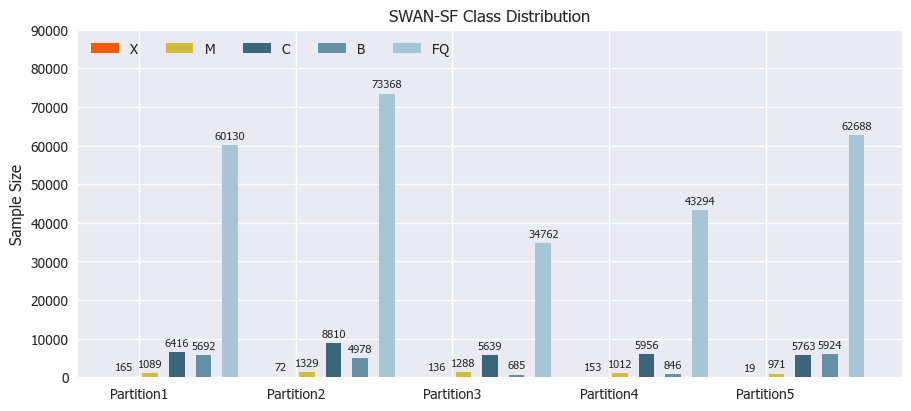

In [6]:
# Create dictionary for counts of each flare type
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

flare_types = {"X": [0,0,0,0,0], "M": [0,0,0,0,0], "C": [0,0,0,0,0], "B": [0,0,0,0,0], "FQ": [0,0,0,0,0]}
color = ['#f95a00','#d1bc3f','#3b657b','#6590a6','#a6c5d5']
plt.style.use('seaborn-v0_8')


font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

    
for i in range(1,6):

    # For each objects flare type sort into M, X, C, B, or FQ, otherwise skip
    for j in labels[i-1]['FLARE_TYPE']:
        if "M" in j:
            flare_types["M"][i-1] +=1
        elif "X" in j:
            flare_types["X"][i-1] +=1
        elif "C" in j:
            flare_types["C"][i-1] +=1
        elif "B" in j:
            flare_types["B"][i-1] +=1
        elif "FQ" in j:
            flare_types["FQ"][i-1] +=1
        else:
            continue


group = ("Partition1", "Partition2", "Partition3", "Partition4", "Partition5")

x = np.arange(len(group))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', sharey=True,
  figsize=(9, 4))

for attribute, measurement in flare_types.items():
    offset = width * multiplier * 1.7
    rects = ax.bar(x + offset, measurement, width, label=attribute, color = color[multiplier] )
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sample Size')
ax.set_title('SWAN-SF Class Distribution')
ax.set_xticks(x + width, group)
ax.legend(loc='upper left', ncols=5)
ax.set_ylim(0, 90000)

plt.show()

# Missing value Exploration

In [53]:
import pickle
import numpy as np

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/raw/"
data = []

for i in range(1,6):
# Load the array with Pickle
    with open(data_dir + "partition" + str(i) + ".pkl", 'rb') as f:
        data.append(pickle.load(f))

In [48]:
abt_header = ['Timestamp', 'R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                           'USFLUX','TOTFZ','MEANPOT', 'EPSX', 'EPSY','EPSZ','MEANSHR','SHRGT45','MEANGAM',
                              'MEANGBT','MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']

null_count = [0,0,0,0,0]
non_null_count = [0,0,0,0,0]
null_count_per_feature = np.zeros((5,125), dtype=int)

for i in range(1,6):
    partition = np.array(data[i-1])
    
    for j in range(1,partition.shape[2]):
        mvts = partition[:,:, j-1]
        for m in range(1,26):
            for n in range (1,61):
                if (mvts[n-1,m-1] == 0.0 or mvts[n-1,m-1] == np.nan):
                    null_count[i-1] += 1
                    null_count_per_feature[i-1,m-1] += 1
                else:
                    non_null_count[i-1] += 1
    
    print("Partition" + str(i) + ":")
    print("null counts in P" + str(i) + ": " + str(null_count[i-1]))
    print("non-null counts in P"+ str(i) + ": " + str(non_null_count[i-1]))
    for x in range(1,26):
        print(abt_header[x-1] + ": " + str(null_count_per_feature[i-1,x-1]))
    
    print("\n")

Partition1:
null counts in P1: 2487130
non-null counts in P1: 107749370
Timestamp: 0
R_VALUE: 2399204
TOTUSJH: 652
TOTBSQ: 652
TOTPOT: 652
TOTUSJZ: 652
ABSNJZH: 652
SAVNCPP: 652
USFLUX: 652
TOTFZ: 652
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0
SHRGT45: 81406
MEANGAM: 0
MEANGBT: 0
MEANGBZ: 0
MEANGBH: 0
MEANJZH: 0
TOTFY: 652
MEANJZD: 0
MEANALP: 0
TOTFX: 652


Partition2:
null counts in P2: 4002443
non-null counts in P2: 128831557
Timestamp: 0
R_VALUE: 2934858
TOTUSJH: 93300
TOTBSQ: 93300
TOTPOT: 93300
TOTUSJZ: 93300
ABSNJZH: 93300
SAVNCPP: 93300
USFLUX: 93300
TOTFZ: 93300
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0
SHRGT45: 134585
MEANGAM: 0
MEANGBT: 0
MEANGBZ: 0
MEANGBH: 0
MEANJZH: 0
TOTFY: 93300
MEANJZD: 0
MEANALP: 0
TOTFX: 93300


Partition3:
null counts in P3: 1472336
non-null counts in P3: 62291164
Timestamp: 0
R_VALUE: 1361036
TOTUSJH: 2718
TOTBSQ: 2718
TOTPOT: 2718
TOTUSJZ: 2718
ABSNJZH: 2718
SAVNCPP: 2725
USFLUX: 2718
TOTFZ: 2718
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0

# MVTS visualization

In [49]:
sample_flare_index = [0,0,0,0,0]

for i in range(0,len(labels[0]['FLARE_CLASS'])):
    if labels[0]['FLARE_CLASS'][i] == 'X':
        sample_flare_index[0] = i
    elif labels[0]['FLARE_CLASS'][i] == 'M':
        sample_flare_index[1] = i
    elif labels[0]['FLARE_CLASS'][i] == 'C':
        sample_flare_index[2] = i
    elif labels[0]['FLARE_CLASS'][i] == 'B':
        sample_flare_index[3] = i
    elif labels[0]['FLARE_CLASS'][i] == 'FQ':
        sample_flare_index[4] = i
    
    count = 0
    for j in range(0,5):
        if sample_flare_index[j] != 0:
            count += 1
    if count == 5:
        break
       

In [50]:
from scipy.stats import zscore
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)

color = ['#f95a00','#d1bc3f','#3b657b','#6590a6','#a6c5d5']
label = ['X', 'M', 'C', 'B', 'FQ']

def plot_time_series_class(data, class_name, ax, n_steps=10):
    
    time_series_df = pd.DataFrame(data)
    
    for i in range(0,5):
        
        temp = time_series_df[i].to_numpy()
        new_2d = temp.reshape(len(time_series_df[i]), 1)
        new_1d = imputer.fit_transform(new_2d)[:,0]
        time_series_df[i] = zscore(pd.DataFrame(new_1d))
        
    
        smooth_path = time_series_df[i].rolling(n_steps).mean()
        ax.plot(smooth_path, linestyle='-', linewidth=1, label=label[i], color=color[i])
    

    ax.set_ylabel(class_name)
    ax.legend();

In [54]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8')


font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

abt_header = ['R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                           'USFLUX','TOTFZ','MEANPOT', 'EPSX', 'EPSY','EPSZ','MEANSHR','SHRGT45','MEANGAM',
                              'MEANGBT','MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']

fig, axs = plt.subplots(12,2, sharey=True,
  figsize=(10, 36))

sample_flare_mvts = np.zeros((60,25,5))

for i in range(0,5):
    sample_flare_mvts[:,:, i] = data[0][:,:, sample_flare_index[i]]
    
    timestamp = sample_flare_mvts[:,0, i]

    start_time = str(timestamp[0])[0:4] + '-' + str(timestamp[0])[4:6] + '-' + str(timestamp[0])[6:8] \
                + ' ' + str(timestamp[0])[8:10] + ":" + str(timestamp[0])[10:12]

    end_time = str(timestamp[59])[0:4] + '-' + str(timestamp[59])[4:6] + '-' + str(timestamp[59])[6:8] \
                + ' ' + str(timestamp[59])[8:10] + ":" + str(timestamp[59])[10:12]

    if i == 0:
        print('Class: X') 
    elif i == 1:
        print('Class: M') 
    elif i == 2:
        print('Class: C') 
    elif i == 3:
        print('Class: B') 
    else:
        print('Class: FQ') 
        
    print('Start Time: ' + start_time + '  and  End Time: ' + end_time)


for i, cls in enumerate(abt_header):
    ax = axs.flat[i]
    data = sample_flare_mvts[:,i+1,:]
    
    plot_time_series_class(data, cls, ax)

fig.tight_layout();
    

Class: X
Start Time: 2012-03-03 18:24  and  End Time: 2012-03-04 06:12
Class: M
Start Time: 2011-02-16 23:00  and  End Time: 2011-02-17 10:48
Class: C
Start Time: 2011-02-07 07:48  and  End Time: 2011-02-07 19:36
Class: B
Start Time: 2011-01-23 22:24  and  End Time: 2011-01-24 10:12
Class: FQ
Start Time: 2011-04-30 05:36  and  End Time: 2011-04-30 17:24


# KNN Imputation 

In [1]:
import pickle
import numpy as np

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/raw/"
data = []

for i in range(1,6):
# Load the array with Pickle
    with open(data_dir + "partition" + str(i) + ".pkl", 'rb') as f:
        data.append(pickle.load(f))

In [6]:
# Inter Column and Between Instance Imputation

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/imputed/"

from tqdm import tqdm

k = 100
number_of_partitions = 5
for i in range(0,number_of_partitions):
    new_partition = np.zeros((60,25,np.array(data[i]).shape[2]))
    new_partition = np.array(data[i])
    
    with tqdm(np.array(data[i]).shape[2]) as pbar:
        for j in range(0,np.array(data[i]).shape[2]):
            new_column = np.zeros((60,25))  
            new_column = new_partition[:,:,j]
            for m in range(0,24):
                new_column[:,m+1][new_column[:,m+1] == 0] = np.nan
                
                if np.isnan(new_column[:,m+1]).all():
                    for n in range(1, k+1):
                        if np.isnan(new_partition[:,m+1,j-n]).all() == False:
                            new_column[:,m+1] = new_partition[:,m+1,j-n]
                            break
                else:
                    new_2d = new_column[:,m+1].reshape(len(new_column[:,m+1]), 1)
                    new_column[:,m+1] = imputer.fit_transform(new_2d)[:,0]
                 
                
                
            new_partition[:,:,j] = new_column

            pbar.update(1)

        with open(data_dir + "partition" + str(i+1) + "_imputed" + ".pkl", 'wb') as f:
            pickle.dump(new_partition, f)
            
            
# Between Instance Imputation

1321it [00:03, 420.15it/s]


KeyboardInterrupt: 

In [12]:
import pickle
import numpy as np

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/imputed/"
data = []

number_of_partitions = 3 #5
for i in range(1,number_of_partitions +1):
# Load the array with Pickle
    with open(data_dir + "partition" + str(i) + "_imputed" + ".pkl", 'rb') as f:
        data.append(pickle.load(f))
        

4.983792076065095


In [4]:
abt_header = ['Timestamp', 'R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                           'USFLUX','TOTFZ','MEANPOT', 'EPSX', 'EPSY','EPSZ','MEANSHR','SHRGT45','MEANGAM',
                              'MEANGBT','MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']

null_count = [0,0,0,0,0]
non_null_count = [0,0,0,0,0]
null_count_per_feature = np.zeros((5,125), dtype=int)

number_of_partitions = 5

for i in range(1,number_of_partitions+1):
    partition = np.array(data[i-1])
    
    for j in range(1,partition.shape[2]):
        mvts = partition[:,:, j-1]
        for m in range(1,26):
            for n in range (1,61):
                if (mvts[n-1,m-1] == 0.0 or mvts[n-1,m-1] == np.nan):
                    null_count[i-1] += 1
                    null_count_per_feature[i-1,m-1] += 1
                else:
                    non_null_count[i-1] += 1
    
    print("Partition" + str(i) + ":")
    print("null counts in P" + str(i) + ": " + str(null_count[i-1]))
    print("non-null counts in P"+ str(i) + ": " + str(non_null_count[i-1]))
    for x in range(1,26):
        print(abt_header[x-1] + ": " + str(null_count_per_feature[i-1,x-1]))
    
    print("\n")

Partition1:
null counts in P1: 0
non-null counts in P1: 110236500
Timestamp: 0
R_VALUE: 0
TOTUSJH: 0
TOTBSQ: 0
TOTPOT: 0
TOTUSJZ: 0
ABSNJZH: 0
SAVNCPP: 0
USFLUX: 0
TOTFZ: 0
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0
SHRGT45: 0
MEANGAM: 0
MEANGBT: 0
MEANGBZ: 0
MEANGBH: 0
MEANJZH: 0
TOTFY: 0
MEANJZD: 0
MEANALP: 0
TOTFX: 0


Partition2:
null counts in P2: 0
non-null counts in P2: 132834000
Timestamp: 0
R_VALUE: 0
TOTUSJH: 0
TOTBSQ: 0
TOTPOT: 0
TOTUSJZ: 0
ABSNJZH: 0
SAVNCPP: 0
USFLUX: 0
TOTFZ: 0
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0
SHRGT45: 0
MEANGAM: 0
MEANGBT: 0
MEANGBZ: 0
MEANGBH: 0
MEANJZH: 0
TOTFY: 0
MEANJZD: 0
MEANALP: 0
TOTFX: 0


Partition3:
null counts in P3: 0
non-null counts in P3: 63763500
Timestamp: 0
R_VALUE: 0
TOTUSJH: 0
TOTBSQ: 0
TOTPOT: 0
TOTUSJZ: 0
ABSNJZH: 0
SAVNCPP: 0
USFLUX: 0
TOTFZ: 0
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0
SHRGT45: 0
MEANGAM: 0
MEANGBT: 0
MEANGBZ: 0
MEANGBH: 0
MEANJZH: 0
TOTFY: 0
MEANJZD: 0
MEANALP: 0
TOTFX: 0




# Zscore Normalization (attribute by attribute)

In [2]:
# Column by Column

from scipy.stats import zscore
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/imputed_zscore_attbyatt/"

number_of_partitions = 3 #5

for i in range(0,number_of_partitions):
    new_partition = np.zeros((60,25,np.array(data[i]).shape[2]))
    new_partition = np.array(data[i])
    
    with tqdm(np.array(data[i]).shape[2]) as pbar:
        for j in range(0,np.array(data[i]).shape[2]):
            new_column = np.zeros((60,25))  
            new_column = np.array(data[i])[:,:,j]
            for m in range(0,24):
                new_column[:,m+1] = zscore(new_column[:,m+1])
                
            new_partition[:,:,j] = new_column

            pbar.update(1)

        with open(data_dir + "partition" + str(i+1) + "_imputed_ZScoreAttbyAtt" + ".pkl", 'wb') as f:
            pickle.dump(new_partition, f)

        
                   

88557it [2:18:55, 10.62it/s]


# Zscore Normalization (Flattened)

In [ ]:
# Flattened

from scipy.stats import zscore
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/imputed_zscore_flat/"

number_of_partitions = 3 #5

for i in range(0,number_of_partitions):
    new_partition = np.zeros((60,25,np.array(data[i]).shape[2]))
    new_partition = np.array(data[i])
    
    with tqdm(np.array(data[i]).shape[2]) as pbar:
        for j in range(0,np.array(data[i]).shape[2]):
            flattened = np.zeros((1440))  
            flattened = np.array(data[i])[:,:,j].flatten()[60:1500]
            flattened = zscore(flattened)
            new_column = np.zeros((60,25))  
            new_column[:,0] = np.array(data[i])[:,0,j]
            for m in range(1,25):
                new_column[:,m] = flattened[(m-1)*60:m*60]
                
            new_partition[:,:,j] = new_column

            pbar.update(1)

        with open(data_dir + "partition" + str(i+1) + "_imputed_ZScoreFlattened" + ".pkl", 'wb') as f:
            pickle.dump(new_partition, f)

# Max Min Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/imputed_minmax/"

from tqdm import tqdm

number_of_partitions = 3 #5

for i in range(0,number_of_partitions):
    new_partition = np.zeros((60,25,np.array(data[i]).shape[2]))
    new_partition = np.array(data[i])
    
    with tqdm(np.array(data[i]).shape[2]) as pbar:
        for j in range(0,np.array(data[i]).shape[2]):
            new_column = np.zeros((60,25))  
            new_column = np.array(data[i])[:,:,j]
            for m in range(0,24):
                temp = new_column[:,m+1]
                data_2d = temp.reshape(-1, 1)
                new_column[:,m+1] = scaler.fit_transform(data_2d).flatten()
                
            new_partition[:,:,j] = new_column

            pbar.update(1)

        with open(data_dir + "partition" + str(i+1) + "_imputed_MinMaxScaler" + ".pkl", 'wb') as f:
            pickle.dump(new_partition, f)

# Log, Square, BoxCox, Zscore, and Min Max Normalization

In [5]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from scipy import stats


data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/imputed_log_square_boxcox_zscore_minmax/"

from tqdm import tqdm

number_of_partitions = 3 #5

for i in range(2,number_of_partitions):
    new_partition = np.zeros((60,25,np.array(data[i]).shape[2]))
    new_partition = np.array(data[i])
    
    with tqdm(np.array(data[i]).shape[2]) as pbar:
        for j in range(0,np.array(data[i]).shape[2]):
            new_column = np.zeros((60,25)) 
            new_column = np.array(data[i])[:,:,j]
            minmax = np.zeros(60)
            all_positive = np.zeros(60)
            
            for m in range(0,24):
                the_min = np.min(new_column[:,m+1])
                the_max = np.max(new_column[:,m+1])
                skewness = stats.skew(new_column[:,m+1])
                

                if (the_max - the_min > 10000):
                    if (skewness > 1):
                        if (the_min < 0):
                            all_positive = new_column[:,m+1] + abs(the_min)
                        else:
                            all_positive = new_column[:,m+1]

                        log = np.log(all_positive)
                        zscore = stats.zscore(log)
                        data_2d = zscore.reshape(-1, 1)
                        minmax = scaler.fit_transform(data_2d).flatten()

                    elif (skewness < -1):

                        sqrt = np.sqrt(new_column[:,m+1])
                        zscore = stats.zscore(sqrt)
                        data_2d = zscore.reshape(-1, 1)
                        minmax = scaler.fit_transform(data_2d).flatten()

                    else:

                        zscore = stats.zscore(new_column[:,m+1])
                        data_2d = zscore.reshape(-1, 1)
                        minmax = scaler.fit_transform(data_2d).flatten()

                else:
                    if (skewness > 1 or skewness < -1):

                        if (the_min < 0):
                            all_positive = new_column[:,m+1] + abs(the_min) + 0.1
                        else:
                            all_positive = new_column[:,m+1]

                        boxcox, values = stats.boxcox(all_positive)
                        zscore = stats.zscore(boxcox)
                        data_2d = zscore.reshape(-1, 1)
                        minmax = scaler.fit_transform(data_2d).flatten()

                    else:

                        zscore = stats.zscore(new_column[:,m+1])
                        data_2d = zscore.reshape(-1, 1)
                        minmax = scaler.fit_transform(data_2d).flatten()

                new_column[:,m+1] = minmax
                
            new_partition[:,:,j] = new_column

            pbar.update(1)

        with open(data_dir + "partition" + str(i+1) + "_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".pkl", 'wb') as f:
            pickle.dump(new_partition, f)

42510it [3:10:28,  3.72it/s] 


# Building AR Data

In [57]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/Code/labels/"  # change the path to where your data is stored.

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/raw/"
data = []

for i in range(1,6):
# Load the array with Pickle
    with open(data_dir + "partition" + str(i) + ".pkl", 'rb') as f:
        data.append(pickle.load(f))

In [ ]:
data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/active_regions/"

number_of_partitions = 5 #5
all_data = []
all_data_label = pd.DataFrame()


for i in range(0,number_of_partitions):
    
    if i == 0:
        all_data = np.array(data[i])
        all_data_label = pd.read_csv(data_dir + "partition" + str(i) + "_labels.csv")

    else:
        all_data = np.concatenate((all_data, np.array(data[i])), axis=2)
        all_data_label = pd.concat([all_data_label, pd.read_csv(data_dir + "partition" + str(i) + "_labels.csv")], axis = 0, ignore_index=True)

    
    
print(all_data.shape)

# Train Test Split

Aproach1:
Train: 1,2 Test: 3

Aproach2:
Train: 3,4 Test: 5

Starified Cross Validation (k = 5)

# Data for ML Models (2D .csv with shuffling)

In [20]:
import pickle
import numpy as np

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/imputed_log_square_boxcox_zscore_minmax/"
data = []

number_of_partitions = 3 #5
for i in range(1,number_of_partitions +1):
# Load the array with Pickle
    with open(data_dir + "partition" + str(i) + "_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".pkl", 'rb') as f:
        data.append(pickle.load(f))

a = np.argwhere(np.isnan(data[0]))
print(a[1000:1010])

[[    0     1 34562]
 [    0     1 34575]
 [    0     1 34576]
 [    0     1 34577]
 [    0     1 34578]
 [    0     1 34579]
 [    0     1 34580]
 [    0     1 34595]
 [    0     1 34739]
 [    0     1 34775]]


In [38]:
import pandas as pd
labels = []
data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/labels/"

for i in range(1,6):
    labels.append(pd.read_csv(data_dir + "partition" + str(i) + "_labels.csv"))

In [59]:
# Flatten with Shuffle

def multi_to_uni(start_partition, end_partition, Name, data_dir):
    category_mapping = {'X': 1, 'M': 1, 'B': 0, 'C': 0, 'FQ': 0}

    X_train = pd.DataFrame()
    Y_train = pd.DataFrame()
    
    
    for i in range(start_partition-1,end_partition):
        
        the_labels = pd.DataFrame()
        the_labels['FLARE_CLASS'] = labels[i]['FLARE_CLASS'].map(category_mapping)
        new_partition = np.zeros((np.array(data[i]).shape[2], 1440))
        new_partition_label = np.zeros(np.array(data[i]).shape[2])
        
        with tqdm(np.array(data[i]).shape[2]) as pbar:
            for j in range(0,np.array(data[i]).shape[2]):
                new_column = np.zeros((60,25)) 
                new_column = np.array(data[i])[:,:,j]

                flettened = np.zeros(1440)

                for m in range(1,25):
                    flettened[(m-1)*60:m*60] = new_column[:,m]

                new_partition[j,:] = pd.DataFrame([flettened])
                new_partition_label[j] = the_labels.iloc[j]
                
                
                pbar.update(1)
                
            X_train = pd.concat([X_train, pd.DataFrame(new_partition)], ignore_index=True)
            Y_train = pd.concat([Y_train, pd.DataFrame(new_partition_label)], ignore_index=True)
            
    
    num_samples = len(X_train)
    shuffle_indices = np.random.permutation(num_samples)
    X_train_shuffled = X_train.iloc[shuffle_indices].reset_index(drop=True)
    Y_train_shuffled = Y_train.iloc[shuffle_indices].reset_index(drop=True)
    
    Y_train_shuffled = Y_train_shuffled.rename(columns={0: 'Flare_Class'})

    train_dir =  "&" + str(end_partition) if Name == "Train" else ""
    
    X_train_shuffled.to_csv(data_dir + Name + "_partition" + str(start_partition) 
                   + train_dir + "_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".csv", index=False)

    Y_train_shuffled.to_csv(data_dir + Name + "_Labels_partition" + str(start_partition) 
                   + train_dir + "_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".csv", index=False)


In [60]:
from tqdm import tqdm
import pandas as pd
data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/Final_Train&Test/"

# Aproach1
multi_to_uni(1, 2, "Train", data_dir)
multi_to_uni(3, 3, "Test", data_dir)

73492it [4:41:28,  4.35it/s] 
88557it [2:28:58,  9.91it/s]
42510it [43:09, 16.42it/s]


In [77]:
# NewFeatures with Shuffle

def new_Features(start_partition, end_partition, Name, data_dir):
    category_mapping = {'X': 1, 'M': 1, 'B': 0, 'C': 0, 'FQ': 0}

    X_train = pd.DataFrame()
    Y_train = pd.DataFrame()
    number_of_new_features = 9
    
    for i in range(start_partition-1,end_partition):
        
        the_labels = pd.DataFrame()
        the_labels['FLARE_CLASS'] = labels[i]['FLARE_CLASS'].map(category_mapping)
        new_partition = np.zeros((np.array(data[i]).shape[2], number_of_new_features*24))
        new_partition_label = np.zeros(np.array(data[i]).shape[2])
        
        with tqdm(np.array(data[i]).shape[2]) as pbar:
            for j in range(0,np.array(data[i]).shape[2]):
                new_column = np.zeros((60,25)) 
                new_column = np.array(data[i])[:,:,j]
                

                new_features = np.zeros(number_of_new_features*24)

                for m in range(1,25):
                    mean = np.mean(new_column[:,m])
                    new_features[((m-1)*number_of_new_features) + 0] = mean
                    median = np.median(new_column[:,m])
                    new_features[((m-1)*number_of_new_features) + 1] = median
                    std = np.std(new_column[:,m])
                    new_features[((m-1)*number_of_new_features) + 2] = std
                    skewness = skew(new_column[:,m])
                    new_features[((m-1)*number_of_new_features) + 3] = skewness
                    kurtosis_value = kurtosis(new_column[:,m])
                    new_features[((m-1)*number_of_new_features) + 4] = kurtosis_value
                    
                    indices = np.arange(60)
                    weight_array = indices / 60
                    weighted_avg = np.average(new_column[:,m], weights=weight_array)
                    new_features[((m-1)*number_of_new_features) + 5] = weighted_avg
                    
                    last_value = new_column[59,m]
                    new_features[((m-1)*number_of_new_features) + 6] = last_value
                    first_value = new_column[0,m]
                    new_features[((m-1)*number_of_new_features) + 7] = first_value
                    
                    numerator = np.sum((new_column[:,m] - mean) * (indices - np.mean(indices)))
                    denominator = np.sum((new_column[:,m] - mean) ** 2)
                    slope = numerator / denominator
                    new_features[((m-1)*number_of_new_features) + 8] = slope
                
                    
                new_partition[j,:] = pd.DataFrame([new_features])
                new_partition_label[j] = the_labels.iloc[j]
                
                pbar.update(1)
            
            X_train = pd.concat([X_train, pd.DataFrame(new_partition)], ignore_index=True)
            Y_train = pd.concat([Y_train, pd.DataFrame(new_partition_label)], ignore_index=True)

    num_samples = len(X_train)
    shuffle_indices = np.random.permutation(num_samples)
    X_train_shuffled = X_train.iloc[shuffle_indices].reset_index(drop=True)
    Y_train_shuffled = Y_train.iloc[shuffle_indices].reset_index(drop=True)
    
    Y_train_shuffled = Y_train_shuffled.rename(columns={0: 'Flare_Class'})

    train_dir =  "&" + str(end_partition) if Name == "Train" else ""
    
    X_train_shuffled.to_csv(data_dir + Name + "_partition" + str(start_partition) 
                   + train_dir + "NewFeatures_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".csv", index=False)

    Y_train_shuffled.to_csv(data_dir + Name + "_Labels_partition" + str(start_partition) 
                   + train_dir + "NewFeatures_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".csv", index=False)

In [78]:
from tqdm import tqdm
import pandas as pd
from scipy.stats import skew, kurtosis
data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/Final_Train&Test/"

# Aproach1
new_Features(1, 2, "Train", data_dir)
new_Features(3, 3, "Test", data_dir)

73492it [2:03:05,  9.95it/s] 
88557it [2:29:09,  9.90it/s]
42510it [36:28, 19.42it/s]


# Data for DL Models (3D .pkl with shuffling)

In [85]:
# 3D pickle with shuffle

def data_for_sequencemodels(start_partition, end_partition, Name, data_dir):
    
    category_mapping = {'X': 1, 'M': 1, 'B': 0, 'C': 0, 'FQ': 0}
    
    
    
    sequence_length = 60
    num_features = 24
    num_samples = 0
    for p in range(start_partition-1,end_partition):
        num_samples += np.array(data[p]).shape[2]
    count = 0
    
    X_train = np.zeros((num_samples, sequence_length, num_features))
    Y_train = np.zeros(num_samples)

    for i in range(start_partition-1,end_partition):
        
        the_labels = pd.DataFrame()
        the_labels['FLARE_CLASS'] = labels[i]['FLARE_CLASS'].map(category_mapping)

        with tqdm(np.array(data[i]).shape[2]) as pbar:
            for j in range(0,np.array(data[i]).shape[2]):

                X_train[count, :, :] = np.array(data[i])[:,1:25,j]
                Y_train[count] = the_labels['FLARE_CLASS'].iloc[j]
                
                count += 1
                pbar.update(1)

                
    train_dir =  "&" + str(end_partition) if Name == "Train" else ""
    
    num_samples = X_train.shape[0]

    shuffle_indices = np.random.permutation(num_samples)

    X_train_shuffled = X_train[shuffle_indices]
    Y_train_shuffled = Y_train[shuffle_indices]
    

    with open(data_dir + Name + "_partition" + str(start_partition) 
                   + train_dir + "_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".pkl", 'wb') as f:
        pickle.dump(X_train_shuffled, f)
            
    with open(data_dir + Name + "_Labels_partition" + str(start_partition) 
                   + train_dir + "_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".pkl", 'wb') as f:
        pickle.dump(Y_train_shuffled, f)

In [86]:
from tqdm import tqdm
import pandas as pd
data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/Final_Train&Test/"

# Aproach1
data_for_sequencemodels(1, 2, "Train", data_dir)
data_for_sequencemodels(3, 3, "Test", data_dir)

73492it [5:31:23,  3.70it/s] 
88557it [3:03:58,  8.02it/s] 
42510it [31:11, 22.71it/s]


# Evaluation Metrics

In [1]:
def TSS(TP,TN,FP,FN):
    TSS_value = (TP / (TP + FN)) - (FP / (FP + TN))
    return TSS_value

def HSS1(TP,TN,FP,FN):
    HSS1_value = (2 * (TP * TN - FP * FN)) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
    return HSS1_value
    
def HSS2(TP,TN,FP,FN):
    HSS2_value = (2 * (TP * TN - FP * FN)) / ((TP + FP) * (FN + TN) + (TP + FN) * (FP + TN))
    return HSS2_value

def GSS(TP,TN,FP,FN):
    GSS_value = (TP - (TP + FP) * (TP + FN) / (TP + FP + FN + TN))
    return GSS_value

def draw_ROC():
    print('ROC')
    
def leaning_rate():
    print('LR')
    
def accuracy():
    print('ACC')

# Loading Final Data (Approach1 - Flattened)

In [2]:
import pandas as pd

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/Final_Train&Test/"

X_train= pd.read_csv(data_dir + 'Train_partition1&2_imputed_Log_Square_BoxCox_Zscore_MinMax.csv').astype('float32')
Y_train= pd.read_csv(data_dir + 'Train_Labels_partition1&2_imputed_Log_Square_BoxCox_Zscore_MinMax.csv').astype('float32')
X_test= pd.read_csv(data_dir + 'Test_partition3_imputed_Log_Square_BoxCox_Zscore_MinMax.csv').astype('float32')
Y_test= pd.read_csv(data_dir + 'Test_Labels_partition3_imputed_Log_Square_BoxCox_Zscore_MinMax.csv').astype('float32')

# Loading Final Data (Approach1 - New Features)

In [ ]:
import pickle
import numpy as np

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/Final_Train&Test/"

X_train= pd.read_csv(data_dir + 'Train_partition1&2_NewFeatures_imputed_Log_Square_BoxCox_Zscore_MinMax.csv').astype('float32')
Y_train= pd.read_csv(data_dir + 'Train_Labels_partition1&2_NewFeatures_imputed_Log_Square_BoxCox_Zscore_MinMax.csv').astype('float32')
X_test= pd.read_csv(data_dir + 'Test_partition3_NewFeatures_imputed_Log_Square_BoxCox_Zscore_MinMax.csv').astype('float32')
Y_test= pd.read_csv(data_dir + 'Test_Labels_partition3_NewFeatures_imputed_Log_Square_BoxCox_Zscore_MinMax.csv').astype('float32')


# Loading Final Data (Approach1 - 3D)

In [ ]:
import pickle
import numpy as np

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/Final_Train&Test/"
X_train = []
Y_train = []
X_test = []
Y_test = []

with open(data_dir + "Train_partition1&2_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".pkl", 'rb') as f:
    X_train.append(pickle.load(f))
    
with open(data_dir + "Train_Labels_partition1&2_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".pkl", 'rb') as f:
    Y_train.append(pickle.load(f))
    
with open(data_dir + "Test_partition3_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".pkl", 'rb') as f:
    X_test.append(pickle.load(f))
    
with open(data_dir + "Test_Labels_partition3_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".pkl", 'rb') as f:
    Y_test.append(pickle.load(f))

# First round ML

ROCKET, TSF, LSTM, GRU, RNN, (1D-CNN)

In [ ]:
# ROCKET with RidgeClassifierCV
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import Rocket
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import joblib
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from tqdm import tqdm  # Import tqdm


data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/models/rocket/"

X_train = from_2d_array_to_nested(X_train)
X_test = from_2d_array_to_nested(X_test)

rocket = Rocket()
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)

classifier = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10))
progress_bar = tqdm(total=len(classifier.alphas), desc="Fitting")

for alpha in classifier.alphas:
    classifier.alpha = alpha
    classifier.fit(X_train_transform, Y_train)
    progress_bar.update(1)

progress_bar.close()
    

X_test_transform = rocket.transform(X_test)

y_pred = classifier.predict(X_test_transform)

confusion = confusion_matrix(Y_test, y_pred)
tn, fp, fn, tp = confusion.ravel()

tss = TSS(tp,tn,fp,fn)

print("TSS: " + str(tss) + "\n")

print(classification_report(y_pred,Y_test))


joblib.dump(classifier, data_dir + "rocket_model_sgd.pkl")

#loaded_rocket_model = joblib.load(data_dir + "rocket_model_sgd.pkl")

hi00


In [ ]:
disp = ConfusionMatrixDisplay(confusion)
disp.plot()

In [ ]:
# ROCKET with RandomForestClassifier
from sktime.transformations.panel.rocket import Rocket
from sklearn.pipeline import make_pipeline
from tslearn.utils import save_sklearn_model, load_sklearn_model
from sklearn.ensemble import RandomForestClassifier

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/models/rocket/"

rocket_pipeline = make_pipeline(
    Rocket(), RandomForestClassifier())

rocket_pipeline.fit(X_train, y_train)

accuracy = rocket_pipeline.score(X_test, y_test)

save_sklearn_model(rocket_pipeline, data_dir + "rocket_model_forest.pkl")

#loaded_model = load_sklearn_model(data_dir + "rocket_model_forest.pkl")


In [ ]:
# TSF

from sktime.classification.interval_based import TimeSeriesForestClassifier

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/models/rocket/"



tsf_classifier = TimeSeriesForestClassifier(n_estimators=24)
tsf_classifier.fit(X_train, Y_train)
y_pred = tsf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

with open(data_dir + 'tsf_model.pkl', 'wb') as model_file:
    pickle.dump(tsf_classifier, model_file)
    
#with open('tsf_model.pkl', 'rb') as model_file:
    #loaded_tsf_model = pickle.load(model_file)

In [ ]:
# LSTM

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assuming X_train, Y_train, X_test, and Y_test are your numpy variables
# Convert them to PyTorch tensors
X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(Y_train)
X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

# Define a custom LSTM-based model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize hyperparameters
input_size = 24  # Number of features
hidden_size = 64  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
num_classes = 2  # Binary classification

# Create an instance of the LSTMClassifier
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create data loaders for training and testing
train_dataset = TensorDataset(X_train, Y_train.long())  # Ensure Y_train is of type long for cross-entropy loss
test_dataset = TensorDataset(X_test, Y_test.long())

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    true_positive, true_negative, false_positive, false_negative = 0, 0, 0, 0

    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_positive += ((predicted == 1) & (labels == 1)).sum().item()
        true_negative += ((predicted == 0) & (labels == 0)).sum().item()
        false_positive += ((predicted == 1) & (labels == 0)).sum().item()
        false_negative += ((predicted == 0) & (labels == 1)).sum().item()

    accuracy = 100 * correct / total
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f"Accuracy: {accuracy}%")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")



In [ ]:
# GRU

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assuming X_train, Y_train, X_test, and Y_test are your numpy variables
# Convert them to PyTorch tensors
X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(Y_train)
X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

# Define a custom GRU-based model
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Initialize hyperparameters
input_size = 24  # Number of features in each timestamp
hidden_size = 64  # Number of GRU units
num_layers = 2  # Number of GRU layers
num_classes = 2  # Binary classification

# Create an instance of the GRUClassifier
model = GRUClassifier(input_size, hidden_size, num_layers, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create data loaders for training and testing
train_dataset = TensorDataset(X_train, Y_train.long())  # Ensure Y_train is of type long for cross-entropy loss
test_dataset = TensorDataset(X_test, Y_test.long())

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    true_positive, true_negative, false_positive, false_negative = 0, 0, 0, 0

    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_positive += ((predicted == 1) & (labels == 1)).sum().item()
        true_negative += ((predicted == 0) & (labels == 0)).sum().item()
        false_positive += ((predicted == 1) & (labels == 0)).sum().item()
        false_negative += ((predicted == 0) & (labels == 1)).sum().item()

    accuracy = 100 * correct / total
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f"Accuracy: {accuracy}%")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")


In [ ]:
# RNN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assuming X_train, Y_train, X_test, and Y_test are your numpy variables
# Convert them to PyTorch tensors
X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(Y_train)
X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

# Define a custom RNN-based model
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Initialize hyperparameters
input_size = 24  # Number of features in each timestamp
hidden_size = 64  # Number of RNN units
num_layers = 2  # Number of RNN layers
num_classes = 2  # Binary classification

# Create an instance of the RNNClassifier
model = RNNClassifier(input_size, hidden_size, num_layers, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create data loaders for training and testing
train_dataset = TensorDataset(X_train, Y_train.long())  # Ensure Y_train is of type long for cross-entropy loss
test_dataset = TensorDataset(X_test, Y_test.long())

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    true_positive, true_negative, false_positive, false_negative = 0, 0, 0, 0

    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_positive += ((predicted == 1) & (labels == 1)).sum().item()
        true_negative += ((predicted == 0) & (labels == 0)).sum().item()
        false_positive += ((predicted == 1) & (labels == 0)).sum().item()
        false_negative += ((predicted == 0) & (labels == 1)).sum().item()

    accuracy = 100 * correct / total
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f"Accuracy: {accuracy}%")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")


In [ ]:
# CNN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assuming X_train, Y_train, X_test, and Y_test are your numpy variables
# Convert them to PyTorch tensors
X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(Y_train)
X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

# Define a custom 1D CNN-based model
class CNNClassifier(nn.Module):
    def __init__(self, input_size, num_channels, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_channels, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(num_channels * 29, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# Initialize hyperparameters
input_size = 24  # Number of features in each timestamp
num_channels = 32  # Number of convolutional channels
num_classes = 2  # Binary classification

# Create an instance of the CNNClassifier
model = CNNClassifier(input_size, num_channels, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create data loaders for training and testing
train_dataset = TensorDataset(X_train, Y_train.long())  # Ensure Y_train is of type long for cross-entropy loss
test_dataset = TensorDataset(X_test, Y_test.long())

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.permute(0, 2, 1))  # Permute dimensions for CNN
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    true_positive, true_negative, false_positive, false_negative = 0, 0, 0, 0

    for inputs, labels in test_loader:
        outputs = model(inputs.permute(0, 2, 1))  # Permute dimensions for CNN
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_positive += ((predicted == 1) & (labels == 1)).sum().item()
        true_negative += ((predicted == 0) & (labels == 0)).sum().item()
        false_positive += ((predicted == 1) & (labels == 0)).sum().item()
        false_negative += ((predicted == 0) & (labels == 1)).sum().item()

    accuracy = 100 * correct / total
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f"Accuracy: {accuracy}%")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")


# Undersampling and Oversampling

SMOTE, ADASYN, GNI, TimeGAN | (TomekLinks and RUS)

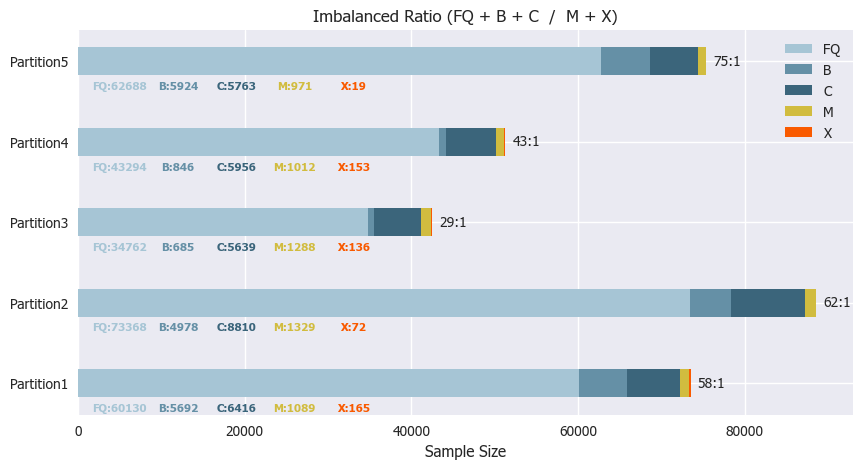

In [8]:
flare_types = {"FQ": [0,0,0,0,0], "B": [0,0,0,0,0], "C": [0,0,0,0,0], "M": [0,0,0,0,0], "X": [0,0,0,0,0]}
imbalanced = {1: [0,0], 2: [0,0], 3: [0,0], 4: [0,0], 5: [0,0]}

plt.style.use('seaborn-v0_8')


font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

color = ['#a6c5d5','#6590a6','#3b657b','#d1bc3f','#f95a00']
group = ["Partition1", "Partition2", "Partition3", "Partition4", "Partition5"]

    
for i in range(1,6):

    # For each objects flare type sort into M, X, C, B, or FQ, otherwise skip
    for j in labels[i-1]['FLARE_TYPE']:
        if "M" in j:
            flare_types["M"][i-1] +=1
            imbalanced[i][0] +=1
        elif "X" in j:
            flare_types["X"][i-1] +=1
            imbalanced[i][0] +=1
        elif "C" in j:
            flare_types["C"][i-1] +=1
            imbalanced[i][1] +=1
        elif "B" in j:
            flare_types["B"][i-1] +=1
            imbalanced[i][1] +=1
        elif "FQ" in j:
            flare_types["FQ"][i-1] +=1
            imbalanced[i][1] +=1
        else:
            continue

            
fig, ax = plt.subplots(sharey=True,
  figsize=(10, 5))

left = np.zeros(len(flare_types.keys()))

for i, col in enumerate(flare_types.keys()):
    ax.barh(
        group, flare_types[col], height=0.35, left=left, label=col, color=color[i])
    left += np.array(flare_types[col])
    
    

totals = [0,0,0,0,0]
for i in range(0,5):
    totals[i] = flare_types['FQ'][i] + flare_types['B'][i] + flare_types['C'][i] + flare_types['M'][i] + \
    flare_types['X'][i]
    
y_offset = 2500
x_offset = - 0.05
for i, total in enumerate(totals):
    ax.text(total + y_offset, i + x_offset, str(str(round(imbalanced[i+1][1] / imbalanced[i+1][0]))+":1"),
            ha='center', weight='normal', size=10)

# Let's put the annotations inside the bars themselves by using a
# negative offset.
x_offset = -0.35
y_offset = -2000
# For each patch (basically each rectangle within the bar), add a label.

# For each patch (basically each rectangle within the bar), add a label.
count = 0
color_number = 0
for bar in ax.patches:
    if count == 5:
        color_number += 1
        count = 0
    count += 1
        
    ax.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
      5000 + color_number * 7000,
      # Vertically, add the height of the bar to the start of the bar,
      # along with the offset.
      bar.get_y() + bar.get_height() / 2 + x_offset,
      # This is actual value we'll show.
      list(flare_types.keys())[color_number] + ':' + str(int(bar.get_width())),
      # Center the labels and style them a bit.
      ha='center',
      color=color[color_number],
      weight='bold',
      size=8
  )

ax.set_title("Imbalanced Ratio (FQ + B + C  /  M + X)")
ax.set_xlabel('Sample Size')

plt.savefig('imbalance.svg')
    
ax.legend()

In [3]:
# SMOTE, TomekLinks, and RUS
# ADASYN, TomekLinks, and RUS

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
import numpy as np

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/Augmented_Train/"

start_partition = 1
end_partition = 2

num_fl_to_oversample = 10000
num_nf_to_keep = 10000

Y_train_0_indices = Y_train[Y_train['Flare_Class'] == 0].index
Y_train_1_indices = Y_train[Y_train['Flare_Class'] == 1].index
random_Y_train_0_indices = np.random.choice(Y_train_0_indices, num_nf_to_keep, replace=False)

X_train_0 = X_train.loc[random_Y_train_0_indices]
X_train_1 = X_train.loc[Y_train_1_indices]
Y_train_0 = Y_train.loc[random_Y_train_0_indices]
Y_train_1 = Y_train.loc[Y_train_1_indices]

X_train_with_RUS = pd.concat([X_train_0, X_train_1], axis=0)
Y_train_with_RUS = pd.concat([Y_train_0, Y_train_1], axis=0)


X_train_with_RUS = X_train_with_RUS.interpolate()

tomek_links = TomekLinks(sampling_strategy='auto')
X_train_RUS_Tomek, Y_train_RUS_Tomek = tomek_links.fit_resample(X_train_with_RUS, Y_train_with_RUS)


smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_RUS_Tomek_Smote, Y_train_RUS_Tomek_Smote = smote.fit_resample(X_train_RUS_Tomek, Y_train_RUS_Tomek)

adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_train_RUS_Tomek_Adasyn, Y_train_RUS_Tomek_Adasyn = adasyn.fit_resample(X_train_RUS_Tomek, Y_train_RUS_Tomek)


print(X_train_RUS_Tomek_Smote.shape)
print(Y_train_RUS_Tomek_Smote.shape)
print(X_train_RUS_Tomek_Adasyn.shape)
print(Y_train_RUS_Tomek_Adasyn.shape)


num_samples = len(X_train_RUS_Tomek_Smote)
shuffle_indices = np.random.permutation(num_samples)
X_train_RUS_Tomek_Smote_shuffled = X_train_RUS_Tomek_Smote.iloc[shuffle_indices].reset_index(drop=True)
Y_train_RUS_Tomek_Smote_shuffled = Y_train_RUS_Tomek_Smote.iloc[shuffle_indices].reset_index(drop=True)


X_train_RUS_Tomek_Smote_shuffled.to_csv(data_dir + 'RUS_Tomek_Smote' + "_partition" + str(start_partition) 
               + "&" + str(end_partition) + "_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".csv", index=False)

Y_train_RUS_Tomek_Smote_shuffled.to_csv(data_dir + 'RUS_Tomek_Smote' + "_Labels_partition" + str(start_partition) 
               + "&" + str(end_partition) + "_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".csv", index=False)


num_samples = len(X_train_RUS_Tomek_Adasyn)
shuffle_indices = np.random.permutation(num_samples)
X_train_RUS_Tomek_Adasyn_shuffled = X_train_RUS_Tomek_Adasyn.iloc[shuffle_indices].reset_index(drop=True)
Y_train_RUS_Tomek_Adasyn_shuffled = Y_train_RUS_Tomek_Adasyn.iloc[shuffle_indices].reset_index(drop=True)


X_train_RUS_Tomek_Adasyn_shuffled.to_csv(data_dir + 'RUS_Tomek_Adasyn' + "_partition" + str(start_partition) 
               + "&" + str(end_partition) + "_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".csv", index=False)

Y_train_RUS_Tomek_Adasyn_shuffled.to_csv(data_dir + 'RUS_Tomek_Adasyn' + "_Labels_partition" + str(start_partition) 
               + "&" + str(end_partition) + "_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".csv", index=False)

(19848, 1440)
(19848, 1)
(20394, 1440)
(20394, 1)


In [4]:
# SMOTE
# ADASYN

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
import numpy as np

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/Augmented_Train/"

start_partition = 1
end_partition = 2


X_train = X_train.interpolate()


smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_Smote, Y_train_Smote = smote.fit_resample(X_train, Y_train)

adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_train_Adasyn, Y_train_Adasyn = adasyn.fit_resample(X_train, Y_train)

print(X_train_Smote.shape)
print(Y_train_Smote.shape)
print(X_train_Adasyn.shape)
print(Y_train_Adasyn.shape)


num_samples = len(X_train_Smote)
shuffle_indices = np.random.permutation(num_samples)
X_train_Smote_shuffled = X_train_Smote.iloc[shuffle_indices].reset_index(drop=True)
Y_train_Smote_shuffled = Y_train_Smote.iloc[shuffle_indices].reset_index(drop=True)


X_train_Smote_shuffled.to_csv(data_dir + 'Smote' + "_partition" + str(start_partition) 
               + "&" + str(end_partition) + "_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".csv", index=False)

Y_train_Smote_shuffled.to_csv(data_dir + 'Smote' + "_Labels_partition" + str(start_partition) 
               + "&" + str(end_partition) + "_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".csv", index=False)



num_samples = len(X_train_Adasyn)
shuffle_indices = np.random.permutation(num_samples)
X_train_Adasyn_shuffled = X_train_Adasyn.iloc[shuffle_indices].reset_index(drop=True)
Y_train_Adasyn_shuffled = Y_train_Adasyn.iloc[shuffle_indices].reset_index(drop=True)


X_train_Adasyn_shuffled.to_csv(data_dir + 'Adasyn' + "_partition" + str(start_partition) 
               + "&" + str(end_partition) + "_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".csv", index=False)

Y_train_Adasyn_shuffled.to_csv(data_dir + 'Adasyn' + "_Labels_partition" + str(start_partition) 
               + "&" + str(end_partition) + "_imputed_Log_Square_BoxCox_Zscore_MinMax" + ".csv", index=False)

(318788, 1440)
(318788, 1)
(318243, 1440)
(318243, 1)


In [ ]:
# GNI, TomekLinks, and RUS

import numpy as np
from sklearn.utils import resample
from imblearn.under_sampling import TomekLinks

# Assuming X_train and Y_train are your numpy variables
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Define the number of FL instances you want to have after oversampling
num_fl_to_oversample = 10000

# Create a TomekLinks undersampler
tomek_links = TomekLinks()

# Fit and transform the data using TomekLinks to remove Tomek links
X_train_no_tomek, Y_train_no_tomek = tomek_links.fit_resample(X_train, Y_train)

# Select 20000 NF instances from the remaining NF instances
nf_indices = np.where(Y_train_no_tomek == 'NF')[0]
selected_nf_indices = np.random.choice(nf_indices, 20000, replace=False)

# Select all FL instances (no oversampling needed for FL)

# Combine the selected NF instances and all FL instances
balanced_X_train = np.concatenate([X_train_no_tomek[selected_nf_indices], X_train[Y_train == 'FL']], axis=0)
balanced_Y_train = np.concatenate([Y_train_no_tomek[selected_nf_indices], Y_train[Y_train == 'FL']], axis=0)

# Generate synthetic FL instances by injecting Gaussian noise (you can customize this)
num_synthetic_fl_instances_needed = num_fl_to_oversample - len(Y_train[Y_train == 'FL'])
synthetic_fl_instances = np.random.normal(loc=balanced_X_train[Y_train == 'FL'].mean(), scale=0.1, size=(num_synthetic_fl_instances_needed, 60, 24))

# Combine the synthetic FL instances with the previously balanced dataset
balanced_X_train = np.concatenate([balanced_X_train, synthetic_fl_instances], axis=0)
balanced_Y_train = np.concatenate([balanced_Y_train, np.array(['FL'] * num_synthetic_fl_instances_needed)], axis=0)

# Now, balanced_X_train and balanced_Y_train contain the balanced dataset
# balanced_X_train.shape should be (30000, 60, 24) and balanced_Y_train.shape should be (30000,)


In [ ]:
# TIMEGAN, TomekLinks, and RUS



# Loading Balanced Data

In [14]:
import pandas as pd

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/Augmented_Train/"
data_dir_test = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/Final_Train&Test/"


X_train= pd.read_csv(data_dir + 'RUS_Tomek_Smote_partition1&2_imputed_Log_Square_BoxCox_Zscore_MinMax.csv').astype('float32')
Y_train= pd.read_csv(data_dir + 'RUS_Tomek_Smote_Labels_partition1&2_imputed_Log_Square_BoxCox_Zscore_MinMax.csv').astype('float32')
X_test= pd.read_csv(data_dir_test + 'Test_partition3_imputed_Log_Square_BoxCox_Zscore_MinMax.csv').astype('float32')
Y_test= pd.read_csv(data_dir_test + 'Test_Labels_partition3_imputed_Log_Square_BoxCox_Zscore_MinMax.csv').astype('float32')

# Second round ML

ROCKET, LSTM, GRU, RNN, TSF (On Augmented data)

In [ ]:
# ROCKET with RidgeClassifierCV
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import Rocket
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import joblib
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from tqdm import tqdm  # Import tqdm


data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/models/rocket/"

X_train = from_2d_array_to_nested(X_train)
X_test = from_2d_array_to_nested(X_test)

rocket = Rocket()
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)

classifier = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10))
progress_bar = tqdm(total=len(classifier.alphas), desc="Fitting")

for alpha in classifier.alphas:
    classifier.alpha = alpha
    classifier.fit(X_train_transform, Y_train)
    progress_bar.update(1)

progress_bar.close()
    

X_test_transform = rocket.transform(X_test)

y_pred = classifier.predict(X_test_transform)

confusion = confusion_matrix(Y_test, y_pred)
tn, fp, fn, tp = confusion.ravel()

tss = TSS(tp,tn,fp,fn)

print("TSS: " + str(tss) + "\n")

print(classification_report(y_pred,Y_test))


joblib.dump(classifier, data_dir + "rocket_model_sgd.pkl")

#loaded_rocket_model = joblib.load(data_dir + "rocket_model_sgd.pkl")

In [ ]:
disp = ConfusionMatrixDisplay(confusion)
disp.plot()

In [ ]:
# ROCKET (ADASYN and RUS)

In [ ]:
# LSTM (SMOTE and RUS)

In [ ]:
# LSTM (ADASYN and RUS)

# Comparison

# Final Visualizations